#### Álvaro Rull y Salvador Heras
Contactos: alvaro.rull@cunef.edu ;
salvador.heras@cunef.edu

# Bloque 2: selección de variables

In [1]:
import pandas as pd 
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics, tree
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE, VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [col_name, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    

def dame_variables_categoricas(dataset=None, max_valores_distintos=100):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
            -- max_valores_distintos: Número máximo de valores distintos permitidos para considerar
                una variable como categórica (por defecto 100)
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de max_valores_distintos valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    
    lista_variables_categoricas = []

    for columna in dataset.columns:
        if pd.api.types.is_object_dtype(dataset[columna]):
            # Si el tipo de dato es 'object' (categórico)
            if len(dataset[columna].dropna().unique()) < max_valores_distintos:
                lista_variables_categoricas.append(columna)

    return lista_variables_categoricas



def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0]]
                                         
            pd_concat_percent = pd_concat_percent
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final


def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.reset_index(drop=True)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

## Cargamos los csv preprocesados previamente guardados

In [3]:
df_fraud = pd.read_csv('./data_preprocesada/df_fraud_initial_preprocessing.csv')\
                      .drop('Unnamed: 0', axis=1)
X_train= pd.read_csv("./data_preprocesada/X_train_preprocessing.csv")\
                      .drop('Unnamed: 0', axis=1)
X_test= pd.read_csv("./data_preprocesada/X_test_preprocessing.csv")\
                      .drop('Unnamed: 0', axis=1)
y_train = pd.read_csv("./data_preprocesada/y_train_preprocessing.csv")\
                      .drop('Unnamed: 0', axis=1)
y_test = pd.read_csv("./data_preprocesada/y_test_preprocessing.csv")\
                      .drop('Unnamed: 0', axis=1)

In [4]:
X_train.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,35
1,float64,17


In [5]:
X_train.head()

,income,customer_age,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,employment_status_1,employment_status_2,employment_status_3,...,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes
0,0.7,20,0,0,0,1,0,1,0,0,...,-0.738722,-0.782290,-1.825344,-1.869019,-0.370654,-0.696005,-0.832206,-0.335069,-0.647820,-0.635759
1,0.1,20,0,0,1,0,0,1,0,0,...,-0.268250,2.345506,2.068506,1.237497,-0.401114,2.085200,-1.678912,NaN,-0.647820,0.101060
2,0.7,50,0,0,0,1,0,1,0,0,...,0.198243,1.726336,0.102213,0.719959,-0.396762,-1.291978,0.660293,1.399862,2.018520,-0.058975
3,0.1,20,0,0,1,0,0,1,0,0,...,-0.089213,-1.363299,0.558082,-0.584307,-0.401114,-0.497348,0.674644,NaN,-0.647820,-0.687068
4,0.9,40,0,0,0,1,0,1,0,0,...,-0.481107,-1.557169,0.549663,-0.575937,-0.381532,-1.093320,2.023634,-1.202534,0.993005,-0.587274


In [6]:
y_train.value_counts()

fraud_bool
0             692301
1               7699
Name: count, dtype: int64

In [7]:
y_train.head()

,fraud_bool
0,0
1,0
2,0
3,0
4,0


### Volvemos a crear nuestra lista de variables numéricas y categóricas despues del escalado y oversampling

In [8]:
list_var_num =  [feature for feature in X_train.columns if X_train[feature].nunique() >= 10]

print(list_var_num)

['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes']


In [9]:
# Create a list of categorical features in the DataFrame X_scaled_nm
list_var_cat = [feature for feature in X_train.columns if X_train[feature].nunique() >= 2 and X_train[feature].nunique() < 10]

print(list_var_cat)

['income', 'customer_age', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4', 'payment_type_5', 'employment_status_1', 'employment_status_2', 'employment_status_3', 'employment_status_4', 'employment_status_5', 'employment_status_6', 'employment_status_7', 'email_is_free', 'housing_status_1', 'housing_status_2', 'housing_status_3', 'housing_status_4', 'housing_status_5', 'housing_status_6', 'housing_status_7', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'source_1', 'source_2', 'device_os_1', 'device_os_2', 'device_os_3', 'device_os_4', 'device_os_5', 'keep_alive_session', 'device_distinct_emails_8w', 'month']


In [10]:
list_var_cat = dame_variables_categoricas(dataset=X_train)
list_var_cat

[]

# Selección de variables

## Regularización Lasso

Debido a que nuestro df X contiene valores NaN es necesario sustituir estos valores por -1

In [11]:
# Sustituir los valores NaN por -1 en el DataFrame X
X_train.fillna(-1, inplace=True)

In [12]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear'), threshold = 0.1) # jugar con el threshold  5e-2
sel_lasso.fit(X_train, y_train)

C:\Users\coke1\anaconda3\envs\practica0\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.1)

In [13]:
sel_lasso.get_support()
selected_feat_lasso = X_train.columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['income', 'payment_type_1', 'payment_type_2', 'payment_type_4',
       'payment_type_5', 'employment_status_1', 'employment_status_2',
       'employment_status_4', 'employment_status_5', 'employment_status_6',
       'employment_status_7', 'email_is_free', 'housing_status_1',
       'housing_status_2', 'housing_status_3', 'housing_status_5',
       'housing_status_6', 'housing_status_7', 'phone_home_valid',
       'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'source_1',
       'source_2', 'device_os_1', 'device_os_2', 'device_os_3', 'device_os_4',
       'device_os_5', 'keep_alive_session', 'device_distinct_emails_8w',
       'name_email_similarity', 'prev_address_months_count', 'zip_count_4w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'bank_months_count', 'proposed_credit_limit'],
      dtype='object')

In [14]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

total features: 52
selected features: 38


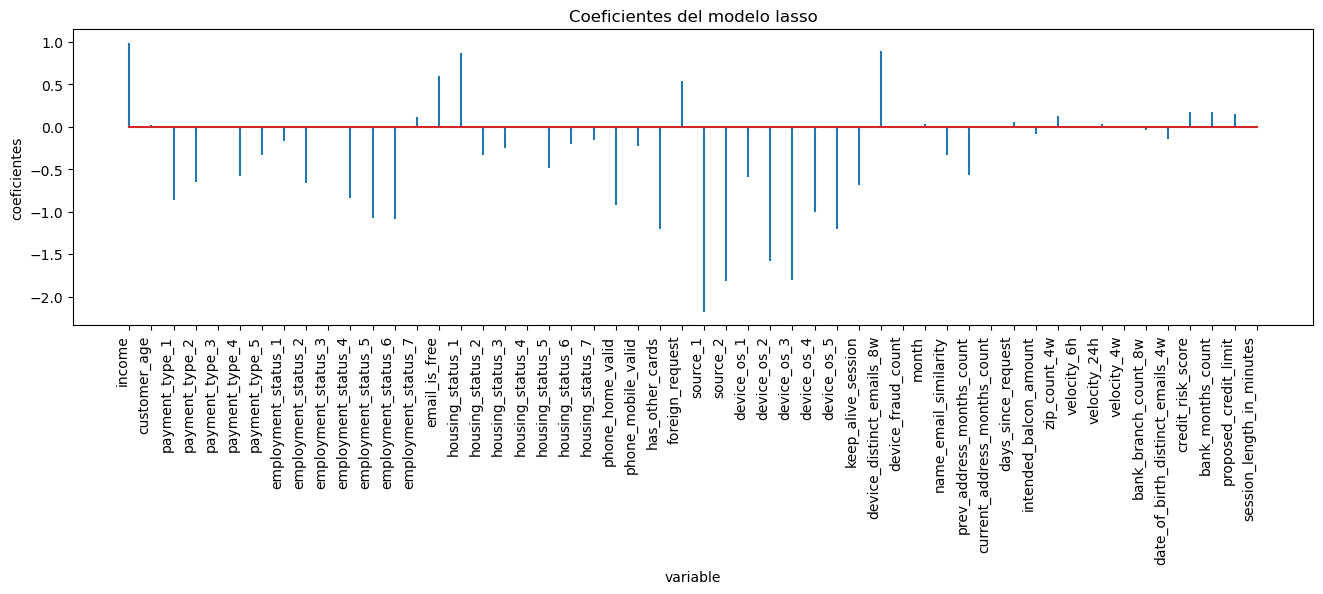

In [15]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

In [16]:
X_lasso_train = X_train[selected_feat_lasso]

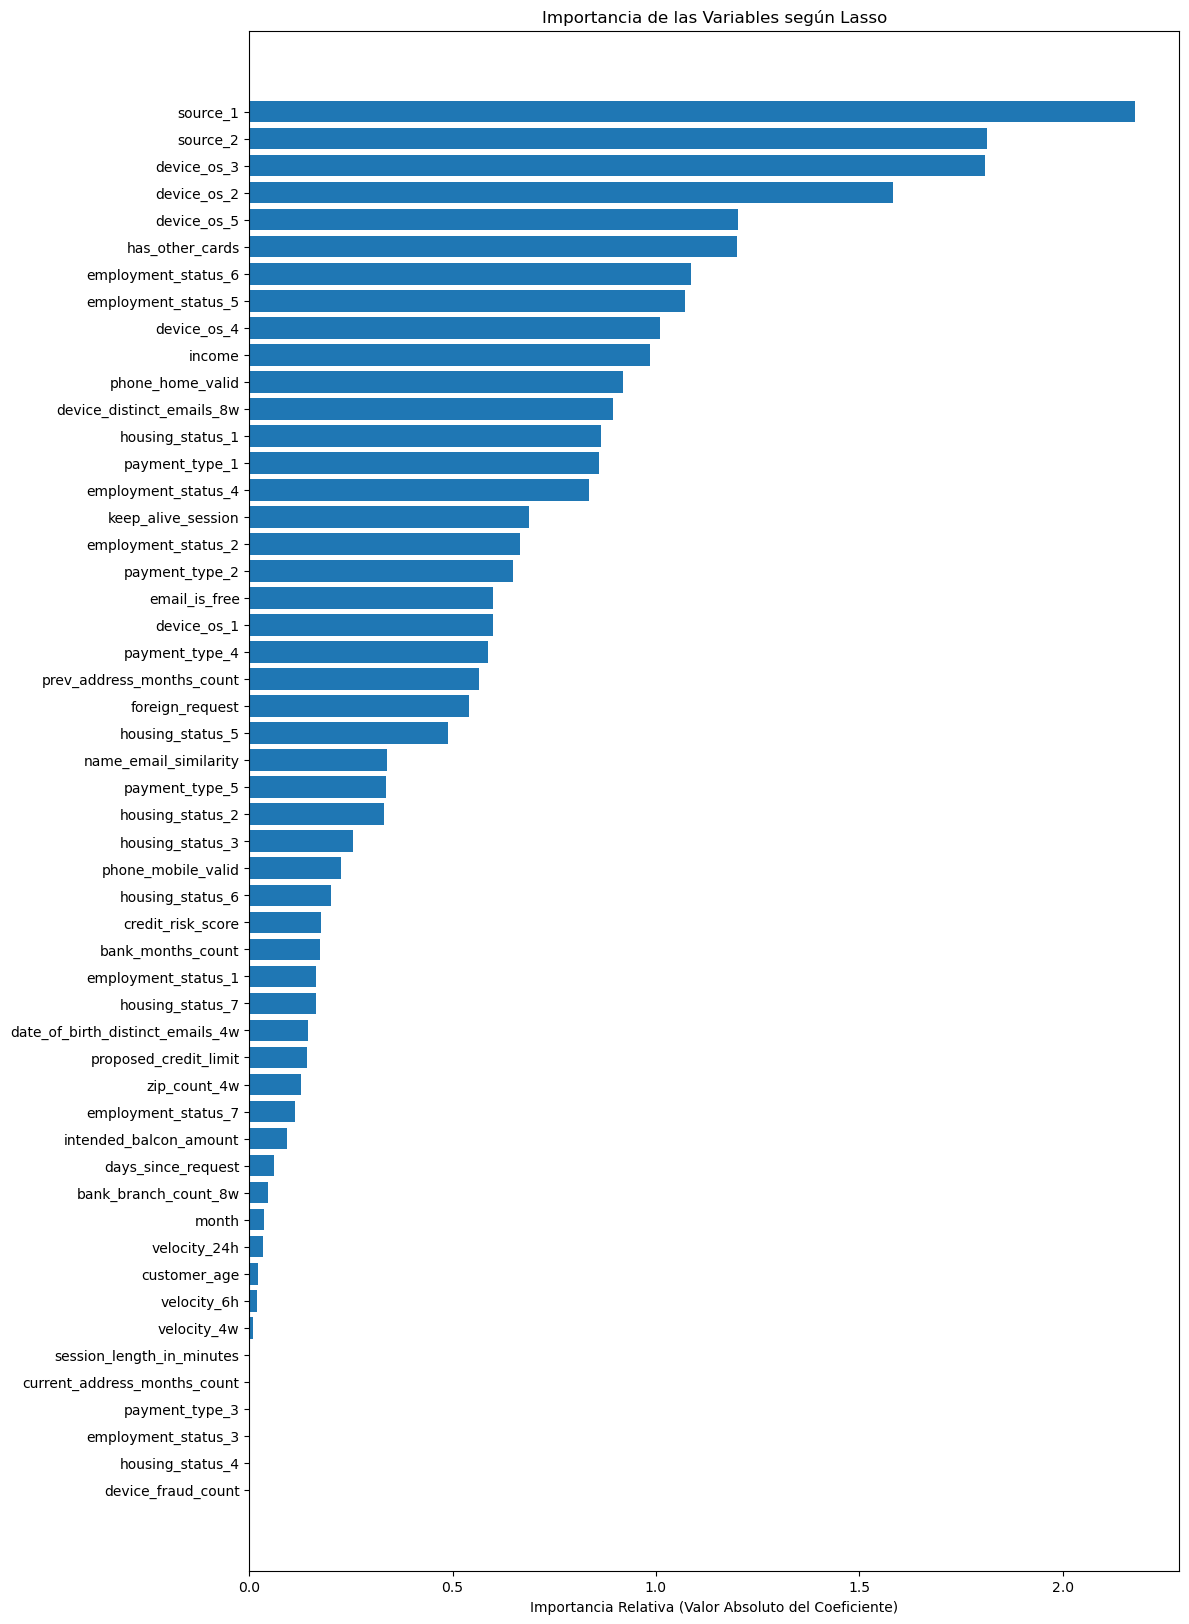

In [17]:
# Coeficientes del modelo Lasso
# ==============================================================================
df_coeficientes_lasso = pd.DataFrame(
    {'predictor': X_train.columns,
     'coef': sel_lasso.estimator_.coef_.flatten()}
)

# Ordenar por valor absoluto
df_coeficientes_lasso['abs_coef'] = np.abs(df_coeficientes_lasso['coef'])
df_coeficientes_lasso = df_coeficientes_lasso.sort_values(by='abs_coef')

# Crear el gráfico de barras horizontales
plt.figure(figsize=(12, 20))
plt.barh(np.arange(len(df_coeficientes_lasso)), df_coeficientes_lasso['abs_coef'], align='center')
plt.yticks(np.arange(len(df_coeficientes_lasso)), df_coeficientes_lasso['predictor'])
plt.xlabel('Importancia Relativa (Valor Absoluto del Coeficiente)')
plt.title('Importancia de las Variables según Lasso')
plt.show()


## Árbol

In [18]:
arbol = tree.DecisionTreeClassifier()

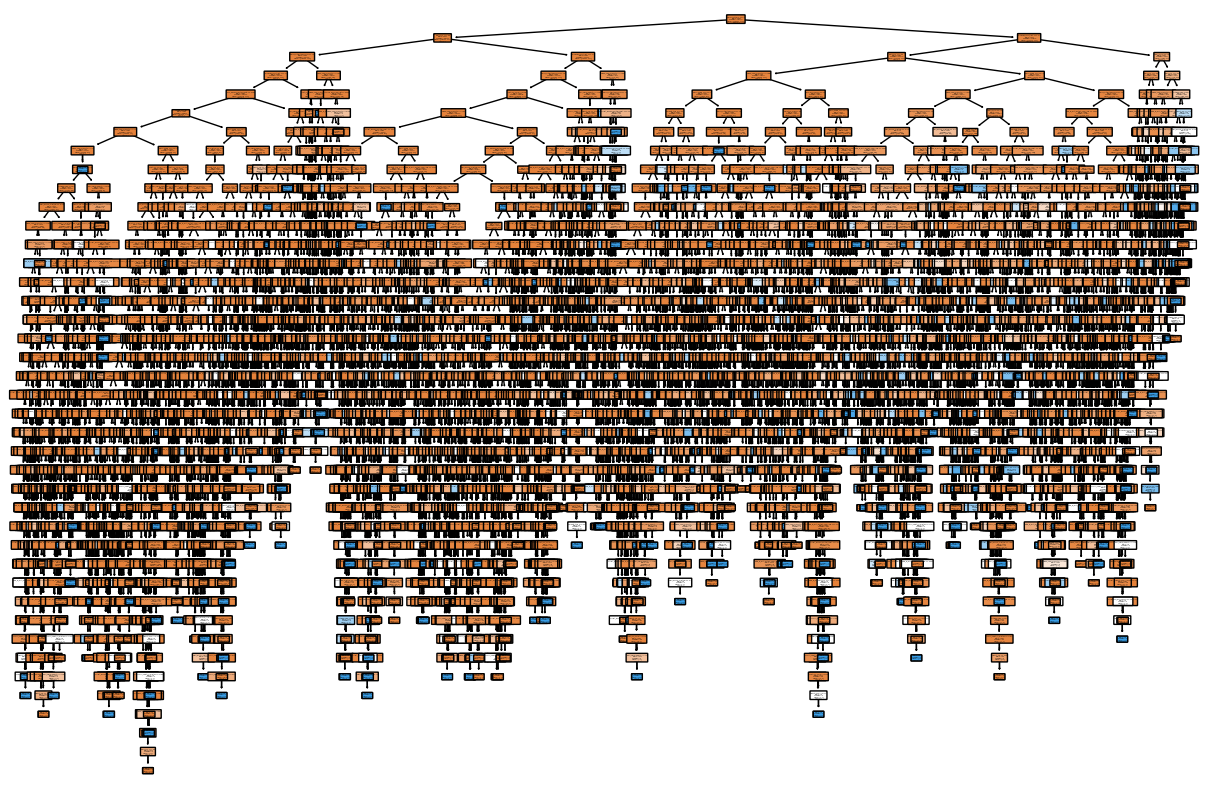

In [19]:
arbol =arbol.fit(X_train, y_train)
plt.figure(figsize=(15, 10))
plot_tree(arbol, feature_names=X_train.columns, class_names=[str(i) for i in arbol.classes_], filled=True, rounded=True)
plt.show()

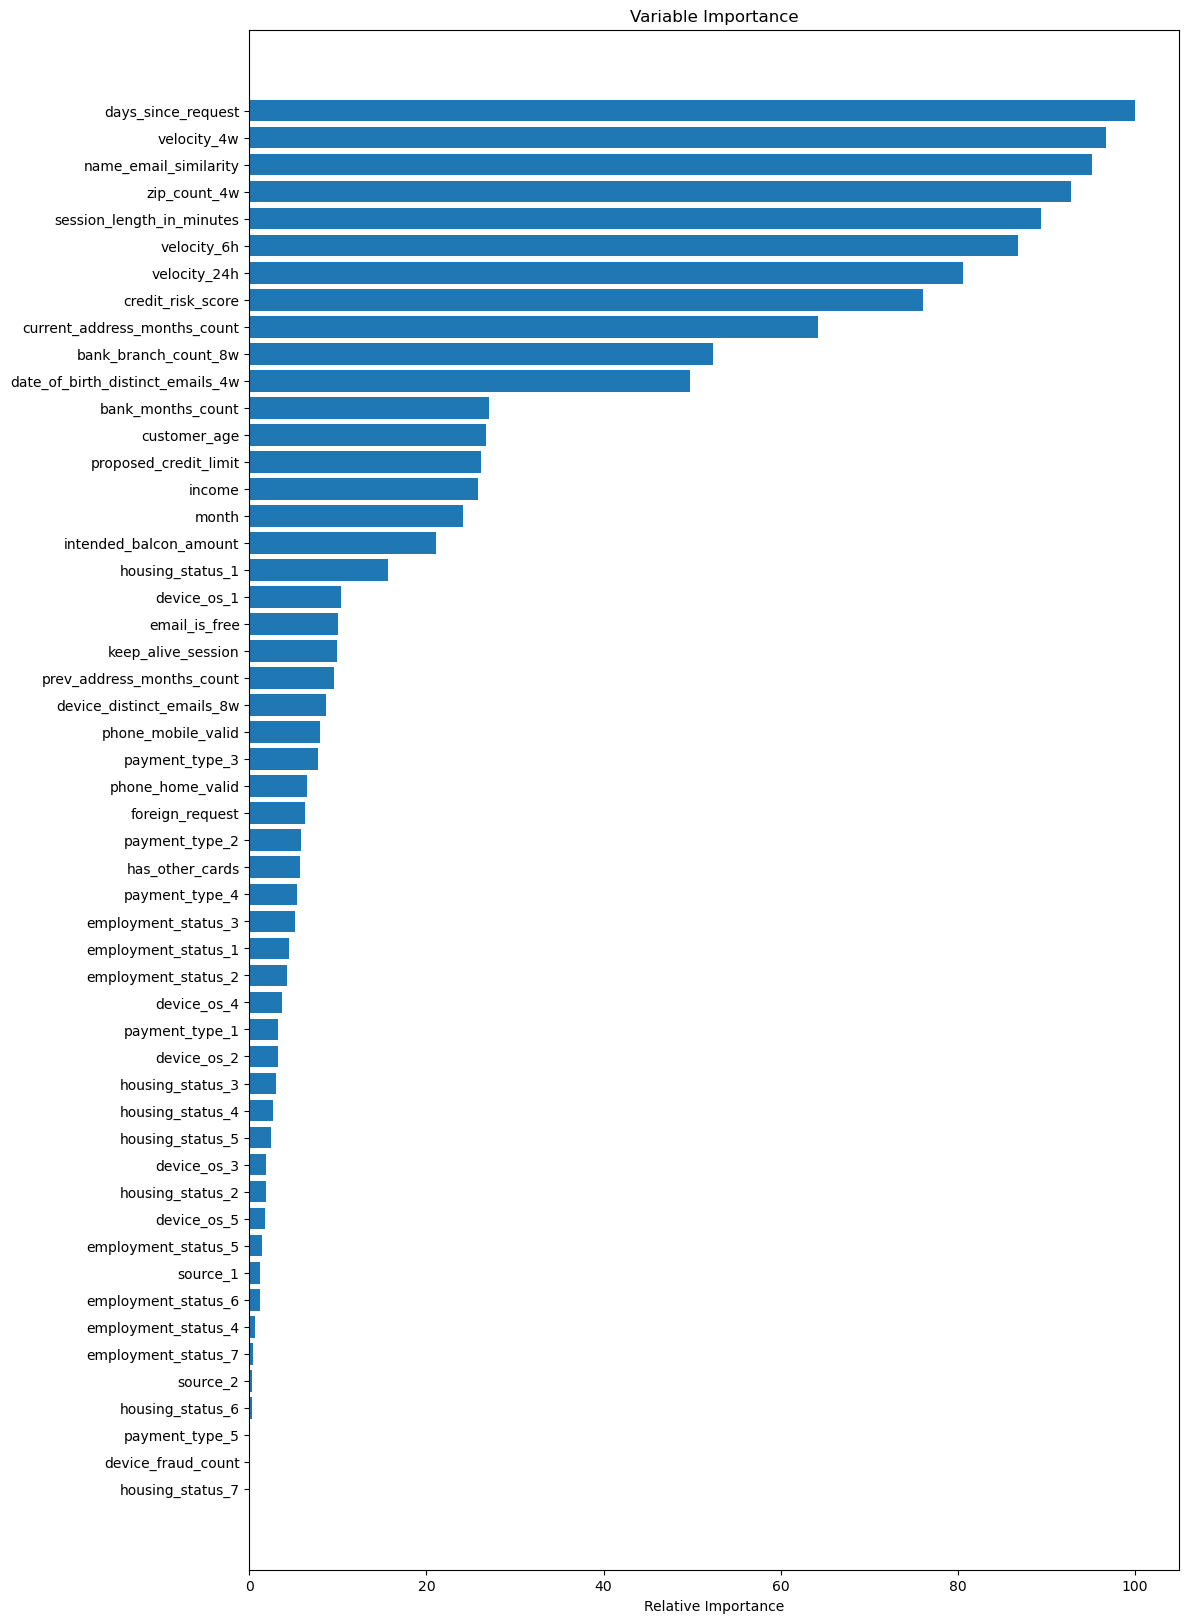

In [20]:
feature_importance = arbol.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Variance Threshold Test for Constant Features

In [21]:
# Instantiate a VarianceThreshold selector and fit it to the training set
selector = VarianceThreshold()
selector.fit(X_train)

# Get the names of the constant features
constant_features = [feature for feature in X_train.columns 
                     if feature not in X_train.columns[selector.get_support()]]

# Print the names of the constant features
print(constant_features)

['device_fraud_count']


## Quitamos las variables que menos importancia tienen en train y test

In [22]:
X_train.drop(['device_fraud_count'], axis=1, inplace=True)
X_test.drop(['device_fraud_count'], axis=1, inplace=True)

In [23]:
X_train.head()
X_test.head()

,income,customer_age,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,employment_status_1,employment_status_2,employment_status_3,...,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes
0,0.1,20,1,0,0,0,0,1,0,0,...,1.293357,-1.144124,-1.668992,-0.731775,-0.379357,-0.497348,-0.416028,NaN,-0.647820,-0.591612
1,0.1,20,0,0,1,0,0,1,0,0,...,-1.070937,0.758771,2.166479,0.738574,-0.398938,1.091912,-0.559538,-1.202534,-0.647820,-0.604263
2,0.4,40,0,1,0,0,0,0,1,0,...,-0.667107,-1.370568,0.580227,0.701371,-0.296681,0.694597,-1.004417,-1.029041,-0.647820,0.776462
3,0.5,20,1,0,0,0,0,0,1,0,...,-0.676059,0.706664,1.271486,2.073027,-0.370654,1.290570,-1.104874,1.139622,-0.647820,-0.620489
4,0.7,50,0,1,0,0,0,1,0,0,...,1.149132,0.801843,1.311693,0.687275,-0.320613,-0.894663,0.229765,1.313115,0.993005,-0.005946


In [24]:
X_train.to_csv("./data_preprocesada/X_train_seleccion.csv")
X_test.to_csv("./data_preprocesada/X_test_seleccion.csv")

Comienza con la carga de un dataset ya procesado, dividido en conjuntos de entrenamiento y prueba, lo que indica que los datos han sido cuidadosamente preprocesados antes de este análisis.

Un aspecto destacado es la metodología empleada para distinguir entre variables numéricas y categóricas, basada en el número de valores únicos, lo que demuestra una comprensión clara de las características del dataset. Esta diferenciación es crucial para aplicar tratamientos estadísticos y de aprendizaje automático adecuados a cada tipo de variable.

Además, el notebook incluye un análisis exploratorio mediante visualizaciones y estadísticas descriptivas. Este enfoque balanceado entre la visualización y el análisis numérico ayuda a obtener una comprensión profunda de las características individuales de los datos, facilitando una interpretación más intuitiva y técnica.

Lo más destacable es la implementación de técnicas avanzadas para la selección de variables, como la Regularización Lasso y el análisis mediante árboles. La Regularización Lasso es conocida por su eficacia en la selección de características al penalizar los coeficientes de regresión, lo que resulta en un modelo más simple y explicativo. El uso de árboles, por otro lado, permite una interpretación visual y estadística de las relaciones entre variables.

El primer gráfico muestra los coeficientes de un modelo Lasso, donde cada barra representa la influencia de una variable en el modelo. Las barras más largas indican variables con mayor impacto, ya sea positivo o negativo, en la predicción del modelo, mientras que las barras más cortas o ausentes representan variables con menor impacto o eliminadas por la regularización.

El segundo gráfico ordena las variables por la importancia relativa en el modelo Lasso, basada en el valor absoluto de los coeficientes. Las variables en la parte superior son las más influyentes, y podrían ser consideradas clave en la toma de decisiones del modelo.

El tercer gráfico es un árbol de decisión muy detallado, reflejando un modelo que ha aprendido una gran cantidad de reglas específicas de los datos. La profundidad y complejidad del árbol sugieren que el modelo puede haber aprendido patrones muy específicos del conjunto de entrenamiento, lo que podría llevar a un riesgo de sobreajuste.

El cuarto gráfico muestra la importancia relativa de las variables según un modelo basado en árboles. Este tipo de gráfico es útil para identificar qué características tienen el mayor peso en la toma de decisiones del modelo y pueden complementar la información proporcionada por Lasso para la selección de variables.

En resumen, estos gráficos proporcionan una visión global de cómo las distintas variables contribuyen al poder predictivo del modelo y pueden ayudar a tomar decisiones informadas sobre qué variables incluir, modificar o eliminar para mejorar el rendimiento del modelo.

Además, siguiendo el código del árbol, aplicamos un bucle para saber que variables son constantes y así poder retirarlas de nuestro dataset. Como resultado obtuvimos que la variable `device_fraud_count` es constante y por lo tanto no nos aporta información.

Los resultados y datos mostrados en el notebook subrayan la efectividad de estas técnicas en la identificación de variables relevantes para el modelo predictivo. Esta selección cuidadosa es fundamental en problemas de detección de fraude, donde la precisión y la interpretación de los resultados son de suma importancia.

En conclusión, el notebook no solo demuestra una sólida comprensión de las técnicas de análisis de datos y selección de variables, sino que también destaca la importancia de un enfoque metódico y bien fundamentado en la preparación de datos para el modelado predictivo. La combinación de análisis detallado, visualización de datos, y aplicación de técnicas estadísticas avanzadas como Lasso y análisis de árboles, prepara de manera eficiente el terreno para el modelado predictivo en la detección de fraude, asegurando que las variables seleccionadas sean las más indicadas para obtener modelos precisos y útiles.